In [2]:
from IPython.display import display, Markdown
display(Markdown(open('README.md','r').read()))

# Modeling Paris traffic

After my previous two studies on `traveling times in Paris` and `traffic in Paris` it is time to model the traffic in Paris. As before, I use the dataset of OpenDataParis reporting the number of cars going through checkpoints fixed on the city every hour.

In this case, by modeling I mean finding a function `F(x(t))=x(t+1h)` to propagate forward of 1h any arbitrary state.
For sake of learning some more tricks with `pytorch`, I'll first make an NN model based on a LSTM cell.

TL;DR: **NOT** a success story yet.

## The model
The model, which contains the NN itself, the optimizer, the data scaler (scikit.learn's RobustScaler) and the data loader is in the file `lstm.py`.

To the incoming data, the time (hour) is appended.

### The NN

```
    Linear(in,hid)->
    Cell(hid,hid)->
    [Cell2(hid,hid)->] *optional layer
    Linear(hid,in)->
    Max(in)
```
The incoming data has `in` dimensions, which are squeezed to `hid` but the linear map,
then the `LSTM` cell operates, and the `hid` counters are decompressed to the original number.
The idea of compressing comes about because PCA showed that 1 mode covers about 90% of the signal, so may be there is no need have a 2000 dimensional LSTM cell.

### Optimization

When learning NN and deep-learning, we are usually confronted with the need to learn the model weights.
But, we need to `learn` or some-how find/optimize the hyperparamters too.

Finding the best hyper-parameters (HP) it's usually a pain. To avoid wasting time,
I turned to the idea that if a set of HP performs better than other on a small number of epochs, it will also perform better on a long optimization.

So a first genetic optimization algorithm (GEA), in `gea.py`, optimizes for the HP leading to the best validation (see later)  in 1000 epochs.
This set of HP are then used to train up to 1e5 epochs (it's really fast, just minutes).

The individuals of the GEA are a dictionary of HP: window size, hidden dimensions, and weight decay.
To evaluate their fitness I simply train the model with the given set of parameters (training is done with `Adam(lr=0.1,momentum=.9)`.

Learning is measured with `MSELoss` or mean-squared-error between the predicted counts and the real ones,
validation is MSE against the average counts at fixed time.

## Result

### On the ML
Well.. we get that the machine does not learn the peaks, and has a rather noisy signal (see below).
Plus, it essentially ignores the time signal. Probably there is a way to get it included.

### On the traffic
Since there is no conservation law, we should not expect the machine to be able to propagate forward
an arbitrary state. There is no conservation of number of car counted implies that cars need to be created and destroied each hour, so the *flux* is more difficult to estimate.

Even with a simple linear model $y_{t+1}=W_{t,t+1}y_t+b_t$ and assuming that $|W|=1$, since the bias is not zero $b_t\neq 0$ the machine can just `learn` the number of expected cars at time $t+1$. Indeed, then it is more efficient to learn $y_{t+1}=0_{t,t+1}y_t+b_t$!

I see no way to estimate the flux.. may be only by keeping the average constant?


In [1]:
%pylab inline
import pandas as pd
from torch.autograd import Variable
from torch import nn
import torch
import glob
import lstm
from lstm import RNN

Populating the interactive namespace from numpy and matplotlib
(288, 2874)


**HP** window 2, hidden dim 28 , weight decay -8 are found with GEA

In [2]:
get_epoch = lambda x:int(x.split('/')[1].split('_')[0])
sorted_epochs = sorted(glob.glob('2_28_-8/*_*'),key=get_epoch)

epochs = []
error_history = []
valid_history = []
for j in sorted_epochs:
    th = open(j+'/train_history.txt','r').readlines()
    for line in th:
        if line:
            step,the,thv=line.split()
            epochs.append(get_epoch(j)+int(step))
            error_history.append(float(the))
            valid_history.append(float(thv))
    

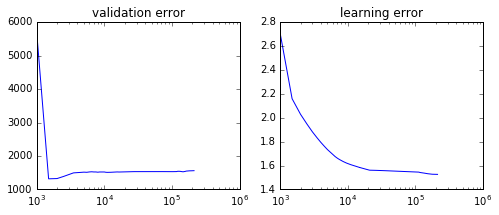

In [3]:
fig,(ax,bx) = plt.subplots(1,2,figsize=(8,3))

ax.semilogx(epochs,valid_history)
bx.semilogx(epochs,error_history)
ax.set_title('validation error')
bx.set_title('learning error')

**load** model after 202000 epochs

In [5]:
model = torch.load('2_28_-8/202000_epochs/model.pth')

/home/astyonax/.anaconda/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/astyonax/.anaconda/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/astyonax/.anaconda/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.loss.MSELoss' has changed. you can retrieve the original source code by accessing the obje

In [6]:
Q = lstm.scaler.fit_transform(lstm.time_series)

## Plot Validation

In [7]:
W=1
real = []
pred = []
model.eval()
time = range(W,Q.shape[0]-1)
for i in time:
    t0 = Q[i-W:i]
    t1 = Q[i]
    t1_pred = model(lstm.np2y(t0)).squeeze().data.numpy()
        
#     print t1.mean(),t1_pred.mean()
    real.append(lstm.scaler.inverse_transform(t1.reshape(1,-1)).mean())
    pred.append(lstm.scaler.inverse_transform(t1_pred.reshape(1,-1)).mean())

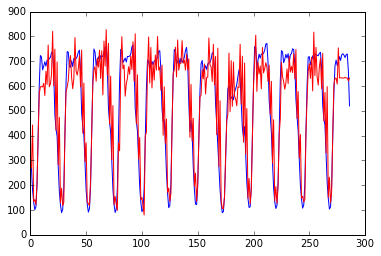

In [8]:
plt.plot(time,real)
plt.plot(time,pred,'r')

### Plot prediction on single counter/feature

In [9]:
real = []
pred = []
model.eval()
w= 2
time = range(w,Q.shape[0]-1)
for i in time:
    t0 = Q[i-w:i]
    t1 = Q[i]
    t1_pred = model(lstm.np2y(t0)).squeeze().data.numpy()
        
#     print t1.mean(),t1_pred.mean()
    real.append(lstm.scaler.inverse_transform(t1.reshape(1,-1)).squeeze()[18])
    pred.append(lstm.scaler.inverse_transform(t1_pred.reshape(1,-1)).squeeze()[18])

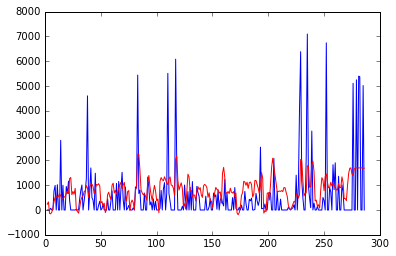

In [10]:
plt.plot(time,real)
plt.plot(time,pred,'r')

## Plot prediction

In [11]:
print(Q.shape)
_t0 = Q.copy()
_t0=_t0[0]
_t0[3:]=np.random.rand(Q.shape[1]-3)*1e5

t0 = lstm.scaler.transform(_t0.reshape(1,-1))
t0.shape


(288, 2874)


(1, 2874)

In [12]:
import copy
model_unbiased = copy.deepcopy(model)

In [13]:
pred = [t0,]
model.eval()
time = range(1,Q.shape[0]-1)
for i in time:
    tprec=t0
    tprec=lstm.scaler.inverse_transform(tprec)
    tprec[:,0]=i%24
    tprec[:,1]=np.cos(i/24.)
    tprec[:,2]=np.sin(i/24.)
    tprec=lstm.scaler.transform(tprec)
    t1 = model(lstm.np2y(tprec)).squeeze().data.numpy()
    pred.append(t1.reshape(1,-1))

pred = np.asarray([lstm.scaler.inverse_transform(j).flatten() for j in pred])

In [14]:
pred.shape

(287, 2874)

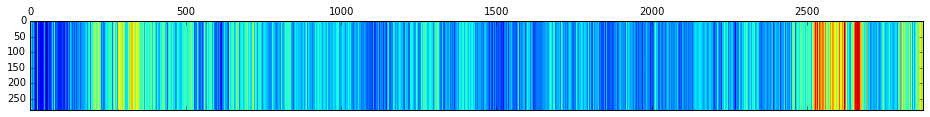

In [15]:
plt.matshow(pred[1:])

### Conclusions - LSTM

So, the machine is learning, definitely, as shown in the previous plots. But
1. It still does not reproduce the high frequency peaks
2. It does not use the information about time, bcs the quantity is essentially discarded when it's the only paramter changing on the input state (prev plot).